In [1]:
# "image": "VizWiz_train_00000000.jpg",
#     "question": "What's the name of this product?",
#     "answers": [
#       {
#         "answer_confidence": "yes",
#         "answer": "basil leaves"
#       },
#      ... 10 odgovora
#      ],
#     "answer_type": "other", yes/no
#     "answerable": 1

In [2]:
import re
import json
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [8]:
def read_csv_file():
    return pd.read_csv('data/ocr.csv')

In [9]:
def read_data(dataset):
    f = open('Annotations/' + dataset + '.json', encoding='utf8')
    data = json.load(f)
    f.close()
    return data

In [10]:
def write_data(data, name):
    json_data = json.dumps(data, indent=2)
    with open(name + '.json', 'w') as f:
        f.write(json_data)

In [14]:
in_train = read_data('train')
in_val = read_data('val')
in_test = read_data('test')

In [63]:
train_len = len(in_train)
val_len = len(in_val)
test_len = len(in_test)
total = train_len + val_len + test_len

print('train ', train_len)
print('val   ', val_len)
print('test  ', test_len)
print()
print('total ', total)

train  20523
val    4319
test   8000

total  32842


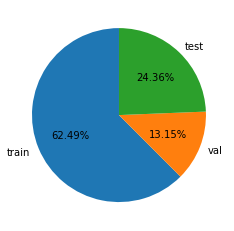

In [64]:
y = np.array([train_len, val_len, test_len])
labels = ["train", "val", "test"]

plt.pie(y, labels=labels, startangle=90, autopct='%1.2f%%')
plt.show()

In [56]:
# BAD-IDEA 0) izbacivanje svih pitanja koje zahtevaju OCR - citanje sa slike!!! - filtrirati po anotiranom skupu???
# DONE     1) izbacivanje svih slika na koje nema odgovora (unanwserable) - DONE
# POTENSL TO-DO 2) svodjenje 10 odgovora na jednu rec (koliko je moguce) - KAKO ODREDITI GLAVNU REC?
#    (naivni pristup - uzmi prvu imenicu ili prvi glagol)
# DONE     3.0)
#             svodjenje svih odgovora na mala slova - DONE
#             izbacivanje specijalnih karaktera (i znakova interpunkcije) - DONE
#             izbacivanje praznina - DONE
#             konverzija unicode u ascii - DONE
# DONE     3) izbacivanje svih slika na koje nemamo koncenzus (svedeni odgovori, nema vise od 3 istih) - DONE
# DONE     4) splitovanje skupa u odnosu da odgovara pocetnom (65:13:22) - DONE
# DONE     5) kreiranje skupa odgovora (odgovori koji se na nivou celog skupa pojavljuju barem 8-12 puta - literatura)
#             (posto smo mi iscistili skup, mozda bi bilo okej da uzmemo sve)
# DONE     6) kreiranje question-answer1,answer2,...,answer1176 csv fajla - ogroman broj featura, ogroman file
#             (mozda smanjiti na reci koje se cesto pojavljuju, u radu su sveli na reci koje se pojavljuju 8-12 puta,
#             UMESTO DA UZMEM SAMO SIGURNE ODGOVORE, UZMEM SIGURNE SLIKE I SVE NJEGOVE ODGOVORE I ONDA GLEDAM KOJI SE POJAVLJUJU VISE PUTA)
# NOT-DONE 7) pretprocesiranje pitanja
#             isto kao 3.0 - DONE
#             plus - word embedding (fastText i gloVe) - drugi fajl
#             plus - charcacter embedding (postoje implementacije)
# NOT-DONE   9) GRU sloj nakon pretprocesiranja svog
# NOT-DONE   8) istraziti character embedding! - GOING DER
# KREIRATI CSV NA ISTI NACIN I ZA TEST DEO SKUPA

### Izbacivanje slika koje zahtevaju OCR

In [14]:
ocr = read_csv_file()

In [15]:
ocr.head()
# izbacujemo sve slike koje za TXT imaju vrednost > 2 (6410 slika)
# nemamo informacije za validacioni i testni 

,IMG,QSN,TXT,OBJ,COL,CNT,OTH
0,VizWiz_train_00000000.jpg,What's the name of this product?,4,3,0,0,0
1,VizWiz_train_00000001.jpg,Can you tell me what is in this can please?,2,5,1,1,0
2,VizWiz_train_00000002.jpg,Is this enchilada sauce or is this tomatoes? ...,4,3,1,0,0
3,VizWiz_train_00000003.jpg,What is the captcha on this screenshot?,4,2,1,1,0
4,VizWiz_train_00000004.jpg,What is this item?,3,5,1,0,0


In [18]:
len(ocr[(ocr['TXT']>0)])

9705

In [23]:
len(ocr[(ocr['TXT']>2)])

6410

In [24]:
len(ocr[(ocr['TXT']>1)])

7998

### Izbacivanje svih slika na koje se ne moze odgovoriti _unanswerable_

In [15]:
labeled = in_train + in_val
answerable = [value for value in labeled if value['answer_type']!='unanswerable']

In [27]:
print(len(labeled))
print(len(answerable))

24842
17925


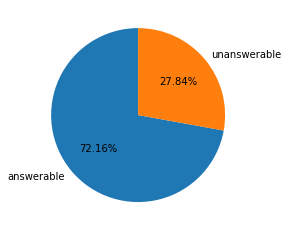

In [91]:
y = np.array([len(answerable), len(labeled)-len(answerable)])
labels = ["answerable", "unanswerable"]

plt.pie(y, labels=labels, startangle=90, autopct='%1.2f%%')
plt.show()

### Pretprocesiranje odgovora

In [16]:
def preprocess_text(text):
    # 1) pretvaranje svih unicode karaktera u ascii (outliers)
    text = unicode_to_ascii(text)
    # 2) izbacivanje belina
    text = remove_blanks(text)
    # 3) izbacivanje specijalnih karaktera
    text = remove_special_characters(text)
    # 4) svodjenje na sva mala slova
    text = to_lower(text)
    return text

In [17]:
def unicode_to_ascii(text):
    return text.encode('ascii', 'ignore').decode('ascii')

In [18]:
def remove_blanks(text):
    without_blanks = text.replace('\\n', ' ').replace('\n', ' ').replace('\t',' ').replace('\\', ' ')
    without_extra_whitespace = re.sub(r'\s+', ' ', without_blanks)
    without_extra_whitespace = without_extra_whitespace.strip()
    return without_extra_whitespace

In [19]:
def remove_special_characters(text):
    return re.sub('[^A-Za-z0-9 ]+', '', text)

In [20]:
def to_lower(text):
    return text.lower()

### Izbacivanje svih slika na koje jednoglasan odgovor (>=30% istih odgovora)

In [21]:
def answer_consensus(data):
    sure_answers = []
    for value in data:
        answers = value['answers']
        # svodjenje na samo sigurne odgovore
        confident_answers = [item['answer'] for item in answers if item['answer_confidence'] == 'yes']
        # pretprocesiranje odgovora
        processed_answers = [preprocess_text(ans) for ans in confident_answers]
        # (odgovor: broj_pojavljivanja) parovi
        counts = Counter(processed_answers)
        # najcesci odgovor koji ima barem 3 pojavljivanja (trecina)
        most_common = [k for (k, v) in counts.items() if v>=3]
        if most_common:
#             if len(most_common)==2:
#                 print(most_common)
#             if len(most_common)==3:
#                 print(most_common)
            # ako postoji, stavi ga u listu sigurnih odgovora TODO UZETI SVE MOST_COMMON
            value['answer'] = most_common
            sure_answers.append(value)
    return sure_answers

In [29]:
sure_answers = answer_consensus(answerable)

In [30]:
print(len(answerable))
print(len(sure_answers))
# ukupno - 17925
# 5 pojavljivanja - 6973
# 3 pojavljivanja - 12514

17925
12532


### Splitovanje skupa na train/val/test

In [31]:
train, val = train_test_split(sure_answers, train_size=0.65)
val, test = train_test_split(val, train_size=0.3)
print(len(train), len(val), len(test))

8145 1316 3071


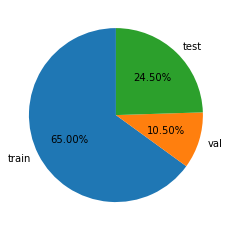

In [144]:
y = np.array([len(train), len(val), len(test)])
labels = ["train", "val", "test"]

plt.pie(y, labels=labels, startangle=90, autopct='%1.2f%%')
plt.show()

## Kreiranje skupa potencijalnih odgovora

In [37]:
# uzmi sve odgovore, prebroj ih, uzmi samo one koji se pojavljuju barem 8 puta
#dict_variable = {key:value for (key,value) in dictonary.items()}
all_answers_with_confidence = [item['answers'] for item in sure_answers]
all_answers = [ans['answer'] for answers in all_answers_with_confidence for ans in answers]
counts = Counter(all_answers)
most_common = [k for (k, v) in counts.items() if v>=8]
# # most_common = [k for (k, v) in counts.items()]
print(len(most_common))
# 5157 unique odgovora
# generalno treshold je 8-12 za ceo skup (2400-3800 potencijalnih odgovora)
# mi smo sveli na polovinu skupa => okej da imamo oko 1000 potencijalnih odgovora (treshold 2 -> 1334)
# ali onda nemamo odgovor validan za pola skupa, so, mejbi sve

2365


## Pitanje-odgovor CSV

In [ ]:
# Question, Answer1, Answer2,..., AnswerN
# uzmi sva pitanja i sve odgovore, napravi tabelu, ako se poklapa, stavi jedinicu

In [24]:
def adapt_dataset(data):
    mlb = MultiLabelBinarizer()
    # binarno popunjava sve odgovore u zavisnosti da li se nalaze u listi za pitanje ili ne
    mlb_result = mlb.fit_transform([value['answer'] for value in data])
    # list(mlb.classes_)
    image_series = pd.Series([question['image'] for question in data])
    q_series = pd.Series([question['question_clean'] for question in data])
    df_final = pd.concat([image_series, q_series, pd.DataFrame(mlb_result, columns=list(mlb.classes_))], axis=1)
    return df_final

In [25]:
df = adapt_dataset(sure_answers)
df.to_csv('data/all.csv', index=False)

KeyError: 'question_clean'

## Rukovanje pitanjima

In [26]:
def clean_question(answer):
    answer['question_clean'] = preprocess_text(answer['question'])
    return answer

In [27]:
cleaned_questions = [clean_question(answer) for answer in sure_answers]

In [28]:
# splitovanje skupa
train, val = train_test_split(cleaned_questions, train_size=0.65)
val, test = train_test_split(val, train_size=0.3)
print(len(train), len(val), len(test))

8145 1316 3071


### Word embedding za pitanja

In [ ]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_x))
tokenized_train_x = tokenizer.texts_to_sequences(train_x)
tokenized_test_x = tokenizer.texts_to_sequences(test_x)

In [5]:
EMB_PATH='C:/Users/evaje/OneDrive/Desktop/Skola skola/Master/1_Semestar/Sistemi za istrazivanje i analizu podataka/projekat/toxic-comment-classification/ksenko/'
EMBEDDING_FILE=EMB_PATH+'emb/glove.6B.50d.txt' # glove
embed_dim = 50
# EMBEDDING_FILE=EMB_PATH+'emb/wiki-news-300d-1M-subword.vec'  # fasttext
# embed_dim = 300

In [6]:
# citanje vektora iz fajla
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_vectors = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE, encoding="utf8"))

In [7]:
all_embs = np.stack(embeddings_vectors.values())
# preuzimanje srednje vrednosti i standardne devijacije
# za generisanje random vektora za reci koje se ne nalaze u korpusu reci embedinga
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


(0.020940498, 0.6441043)

In [ ]:
# broj reci koje jesu u treniranim embedinzima
emb_count = 0

word_index = tokenizer.word_index
# min(broj reci u korpusu, maksimalan broj reci)
nb_words = min(max_features, len(word_index))
# generisanje matrice dimenzija nb_words sa embed_dim sa random vrednostima
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_dim))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_vectors.get(word)
    # ako se rec nalazi medju treniranim embedinzima, uzmi je
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        emb_count += 1
    else:
        print(word)

### Svojedjenje svakog odgovora na glavnu rec (gde je moguce)

In [92]:
bad_image = [value for value in answerable if len([answer for answer in value['answers'] if answer=='unsuitable image'])>0]

In [93]:
print(bad_image)

[]


In [67]:
labeled = in_train + in_val
train, val = train_test_split(labeled, train_size=0.65)
val, test = train_test_split(val, train_size=0.3)
print(len(train), len(val), len(test))

16147 2608 6087


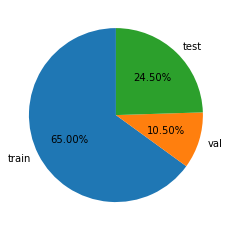

In [68]:
y = np.array([len(train), len(val), len(test)])
labels = ["train", "val", "test"]

plt.pie(y, labels=labels, startangle=90, autopct='%1.2f%%')
plt.show()

In [74]:
write_data(train, 'train')
write_data(val, 'val')
write_data(test, 'test')

In [6]:
answer_types = [value['answer_type'] for value in in_train]

In [7]:
answer_types = np.unique(np.array(answer_types))

In [8]:
# svi tipovi odgovora
answer_types

array(['number', 'other', 'unanswerable', 'yes/no'], dtype='<U12')

In [9]:
# procenat prisustva svakog od tipova u okviru trening i validacionog skupa
train_val = in_train+in_val
answer_type_groups = [[value for value in train_val if value['answer_type']==answer_type] for answer_type in answer_types]

In [10]:
len(answer_type_groups)

4

In [16]:
for group in answer_type_groups:
    print(len(group), group[0]['answer_type'])
    if group[0]['answer_type']=='number':
        for gr in group:
            answers = [ans['answer'] for ans in gr['answers']]
            print(answers)

349 number
['100', '100', '100', '100', '100', '$100', '100', '100 rupees', '100', '100']
['100', '1246063', '100', '100', '100', 'unsuitable', '100', '100', '100', '100']
['7', '1', '7', 'no', 'unsuitable', 'unsuitable', '1', 'unsuitable', '7', 'no']
['73', '73', '73', '73', '73', '73', '73', '73', '73', '73']
['8', 'unsuitable', '8', '8', 'unanswerable', '8', '8', '8', 'unsuitable', 'unsuitable']
['76', 'sd', '76', '76', '76', '76', '76', '76', '76', '76']
['10 club', '10', '10', '10', '10 clubs', '10', '10', '10', '10', '10 clubs']
['68', '65', 'unsuitable', 'unsuitable', 'unanswerable', '68', '65', '65', '88', 'unsuitable']
['819', '0', '819', 'unanswerable', 'unanswerable', 'display has time', '819', '819', 'digital', '819']
['5', '5', '5 dollar bill', '5 dollars', '5', '5', '5 dollars', 'not clear', '$5', '5']
['unanswerable', '31', '16', '40', '0', 'unsuitable', '40f', '40 click zoom', '40 degrees', '40']
['unsuitable', '75', 'unanswerable', '75', 'yes', '75', 'yes', 'no', 'unsu

In [ ]:
print